The purpose of this note book is to apply the profit optiisation model to make predictions based on a set of met office data. This can then also be compared to Manon's results.

The code bellow imports the necessary python packages.

In [1]:
import sys
sys.path.append('../')

from src.vapour_pressure_deficit_calculation import vapour_pressure_deficit
from src.profit_optimisation_model import ProfitOptimisationModel, run_optimisation_model_on_data
from src.cumulative_Weibull_distribution_model import cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials
from src.hydraulic_cost_model import HydraulicCostModel
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.CO2_gain_model import CO2GainModel
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.photosynthesis_model import PhotosynthesisModel
from src.CO2_gain_model import CO2GainModel

from src.conversions import (magnitude_conversion,
                             mole_carbon_to_grams,
                             per_day_to_per_second,
                             per_second_to_per_half_hour,
                             convert_transpiration_rate_to_latent_energy)

from xarray import open_dataset
from pandas import DataFrame, date_range
from numpy import nan

from matplotlib import pyplot as plt

# Metoffice data

To run the model we need a set of environmental data, this we get from a netcdf file. The code bellow imports and prints a description of this file.

In [2]:
metoffice_data_file_address = "../../Example met data/Alice_Holt/data/UK-Ham_2002-2003_Met.nc"

metoffice_data_file = open_dataset(metoffice_data_file_address, decode_times = False)

print(metoffice_data_file)

<xarray.Dataset>
Dimensions:    (time: 17520, z: 1, y: 1, x: 1)
Coordinates:
  * time       (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z          (z) float64 1.0
  * y          (y) float64 1.0
  * x          (x) float64 1.0
Data variables:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    SWdown     (time, y, x) float64 ...
    Tair       (time, y, x) float64 ...
    Precip     (time, y, x) float64 ...
    Qair       (time, y, x) float64 ...
    Wind       (time, y, x) float64 ...
    Psurf      (time, y, x) float64 ...
    LWdown     (time, y, x) float64 ...
    CO2air     (time, z, y, x) float64 ...
    za_tq      (y, x) float64 ...
    za_uv      (y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


We can take a closer look at the available data "columns" using the keys property.

In [3]:
print(metoffice_data_file.keys)

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:    (time: 17520, z: 1, y: 1, x: 1)
Coordinates:
  * time       (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z          (z) float64 1.0
  * y          (y) float64 1.0
  * x          (x) float64 1.0
Data variables:
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    SWdown     (time, y, x) float64 ...
    Tair       (time, y, x) float64 ...
    Precip     (time, y, x) float64 ...
    Qair       (time, y, x) float64 ...
    Wind       (time, y, x) float64 ...
    Psurf      (time, y, x) float64 ...
    LWdown     (time, y, x) float64 ...
    CO2air     (time, z, y, x) float64 ...
    za_tq      (y, x) float64 ...
    za_uv      (y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com>


Alternativly you can inspect a netcdf file without the need to write python code. For example to view the header of the netcdf file from the terminal use the following command: 

$$ \text{ncdump -h file_address} $$

Note the -h restricts the output to only the header, if it is removed the entier file is printed. 

Alternativly for a graphical interface you can open the file using nasas panoply software (https://www.giss.nasa.gov/tools/panoply/download/).

From this file we only want a subset of the columns, specificaly air temperature, specific humidity, air pressure at the ground surface and the $CO_2$ fraction of the air. These columns are labeld Tair, Qair, Psurf and CO2air respectivly. The code bellow reduces the data to just these columns.

In [4]:
met_columns = ["Tair", "Qair", "Psurf", "CO2air"]
metoffice_data = metoffice_data_file[met_columns]

print(metoffice_data)

<xarray.Dataset>
Dimensions:  (time: 17520, y: 1, x: 1, z: 1)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
  * z        (z) float64 1.0
  * y        (y) float64 1.0
  * x        (x) float64 1.0
Data variables:
    Tair     (time, y, x) float64 ...
    Qair     (time, y, x) float64 ...
    Psurf    (time, y, x) float64 ...
    CO2air   (time, z, y, x) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


We can see that each column is actualy three dimentional. The first dimension coressponds to the time at wich the measurment is conducted. The remaining two dimentions "x" and "y" are needed when running simulations over a grid of adjacent sites, and "z" is used to brake the atmospher into different cells. The data in this particular file only uses one site and a single hight cell so we can remove these three diemtions.

In [5]:
metoffice_data = metoffice_data.squeeze(dim=["x", "y", "z"], drop = True)

print(metoffice_data)

<xarray.Dataset>
Dimensions:  (time: 17520)
Coordinates:
  * time     (time) float64 0.0 1.8e+03 3.6e+03 ... 3.153e+07 3.153e+07
Data variables:
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    Psurf    (time) float64 ...
    CO2air   (time) float64 ...
Attributes:
    description:    Alice Holt met data, created by Martin De Kauwe
    history:        Created by: generate_met_file_2022_JULES.py
    creation_date:  2023-06-30 12:33:02.874471
    contact:        mdekauwe@gmail.com


Next we convert this into a pandas data frame to make it easier to work with.

In [6]:
metoffice_data = metoffice_data.to_pandas()

print(metoffice_data)

               Tair      Qair     Psurf  CO2air
time                                           
0.0         289.322  0.006778  101608.0  418.56
1800.0      289.322  0.006778  101608.0  418.56
3600.0      287.886  0.006796  101628.0  418.56
5400.0      287.886  0.006796  101628.0  418.56
7200.0      286.193  0.006731  101659.0  418.56
...             ...       ...       ...     ...
31527000.0  285.735  0.006571   99948.7  418.56
31528800.0  286.414  0.006736   99905.7  418.56
31530600.0  286.414  0.006736   99905.7  418.56
31532400.0  285.521  0.007251   99803.2  418.56
31534200.0  285.521  0.007251   99803.2  418.56

[17520 rows x 4 columns]


Inorder to run the profit optimisation model we need the vapour pressure deficit in $kPa$.

In [7]:
metoffice_data['VPD'] = vapour_pressure_deficit(metoffice_data['Tair'],
                                                metoffice_data['Qair'],
                                                metoffice_data['Psurf'])

print(metoffice_data)

               Tair      Qair     Psurf  CO2air       VPD
time                                                     
0.0         289.322  0.006778  101608.0  418.56  0.734297
1800.0      289.322  0.006778  101608.0  418.56  0.734297
3600.0      287.886  0.006796  101628.0  418.56  0.569528
5400.0      287.886  0.006796  101628.0  418.56  0.569528
7200.0      286.193  0.006731  101659.0  418.56  0.405156
...             ...       ...       ...     ...       ...
31527000.0  285.735  0.006571   99948.7  418.56  0.404794
31528800.0  286.414  0.006736   99905.7  418.56  0.445145
31530600.0  286.414  0.006736   99905.7  418.56  0.445145
31532400.0  285.521  0.007251   99803.2  418.56  0.277809
31534200.0  285.521  0.007251   99803.2  418.56  0.277809

[17520 rows x 5 columns]


The time column here is not in the format we necesseraly want so lets create another column with the date and time of each measurement.

In [8]:
units, reference_date = metoffice_data_file.time.attrs['units'].split('since')

start = reference_date.strip()[0:19].replace("-","/")

metoffice_data['date time'] = date_range(start = start, periods = len(metoffice_data), freq = '30MIN')

metoffice_data = metoffice_data.set_index('date time')

print(metoffice_data)

                        Tair      Qair     Psurf  CO2air       VPD
date time                                                         
2022-01-01 00:00:00  289.322  0.006778  101608.0  418.56  0.734297
2022-01-01 00:30:00  289.322  0.006778  101608.0  418.56  0.734297
2022-01-01 01:00:00  287.886  0.006796  101628.0  418.56  0.569528
2022-01-01 01:30:00  287.886  0.006796  101628.0  418.56  0.569528
2022-01-01 02:00:00  286.193  0.006731  101659.0  418.56  0.405156
...                      ...       ...       ...     ...       ...
2022-12-31 21:30:00  285.735  0.006571   99948.7  418.56  0.404794
2022-12-31 22:00:00  286.414  0.006736   99905.7  418.56  0.445145
2022-12-31 22:30:00  286.414  0.006736   99905.7  418.56  0.445145
2022-12-31 23:00:00  285.521  0.007251   99803.2  418.56  0.277809
2022-12-31 23:30:00  285.521  0.007251   99803.2  418.56  0.277809

[17520 rows x 5 columns]


## Missing model inputs

The data available within the file doesn't contain the soil water potential or intercellular oxygen concentration so for now we set these values. The code used later takes these values in as an array of the same size as time steps so we need to create one for each and add it to the pandas data frame.

In [9]:
soil_water_potential = -0.0 # MPa
intercellular_oxygen = 210.0 #(umol mol-1)

metoffice_data['soil water potential'] = soil_water_potential
metoffice_data['intercellular oxygen'] = intercellular_oxygen

print(metoffice_data)

                        Tair      Qair     Psurf  CO2air       VPD  \
date time                                                            
2022-01-01 00:00:00  289.322  0.006778  101608.0  418.56  0.734297   
2022-01-01 00:30:00  289.322  0.006778  101608.0  418.56  0.734297   
2022-01-01 01:00:00  287.886  0.006796  101628.0  418.56  0.569528   
2022-01-01 01:30:00  287.886  0.006796  101628.0  418.56  0.569528   
2022-01-01 02:00:00  286.193  0.006731  101659.0  418.56  0.405156   
...                      ...       ...       ...     ...       ...   
2022-12-31 21:30:00  285.735  0.006571   99948.7  418.56  0.404794   
2022-12-31 22:00:00  286.414  0.006736   99905.7  418.56  0.445145   
2022-12-31 22:30:00  286.414  0.006736   99905.7  418.56  0.445145   
2022-12-31 23:00:00  285.521  0.007251   99803.2  418.56  0.277809   
2022-12-31 23:30:00  285.521  0.007251   99803.2  418.56  0.277809   

                     soil water potential  intercellular oxygen  
date time              

## Resampling the data

Currently the met data we are working with contains a years worth of measurments seperated byhalf an hour totaling $17520$ entries. To reduce the computation time we will reduce the data to be every six hours (reducing the data to $1460$ entries).

In [10]:
current_time_step = 0.5 #h
target_time_step = 6 #h

resample_step = int(target_time_step / current_time_step)
print("resample step: ", resample_step, "\n")

metoffice_data = metoffice_data.iloc[::resample_step, :]

print(metoffice_data)

resample step:  12 

                        Tair      Qair     Psurf  CO2air       VPD  \
date time                                                            
2022-01-01 00:00:00  289.322  0.006778  101608.0  418.56  0.734297   
2022-01-01 06:00:00  284.987  0.006884  101766.0  418.56  0.264953   
2022-01-01 12:00:00  287.113  0.007292  102050.0  418.56  0.402458   
2022-01-01 18:00:00  285.714  0.007400  102289.0  418.56  0.243053   
2022-01-02 00:00:00  289.322  0.006778  101608.0  418.56  0.734297   
...                      ...       ...       ...     ...       ...   
2022-12-30 18:00:00  287.884  0.007442   98383.9  418.56  0.503225   
2022-12-31 00:00:00  287.105  0.007443   99775.5  418.56  0.404153   
2022-12-31 06:00:00  287.168  0.007439   99423.2  418.56  0.415499   
2022-12-31 12:00:00  285.686  0.006994   98671.7  418.56  0.347002   
2022-12-31 18:00:00  287.884  0.007442   98383.9  418.56  0.503225   

                     soil water potential  intercellular oxygen  
da

# Applying the model

Now that we have the necessary data the next step is to creat the model.

In [11]:
hydraulic_conductance_model = \
    cumulative_weibull_distribution_from_conductance_loss_at_given_water_potentials(maximum_conductance = 1, # mmol m-2 s-1 MPa-1
                                                                                    water_potential_1 = -6.6, # MPa
                                                                                    water_potential_2 = -10.5, # MPa
                                                                                    conductance_loss_fraction_1 = 0.5,
                                                                                    conductance_loss_fraction_2 = 0.88)

critical_leaf_water_potential = hydraulic_conductance_model.water_potential_from_conductivity_loss_fraction(0.95)

hydraulic_cost_model = HydraulicCostModel(hydraulic_conductance_model = hydraulic_conductance_model,
                                          saturated_water_potential = soil_water_potential,
                                          critical_leaf_water_potential = critical_leaf_water_potential)

leaf_air_coupling_model = LeafAirCouplingModel()
photosynthesis_model = PhotosynthesisModel()

CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

profit_optimisation_model = ProfitOptimisationModel(hydraulic_cost_model,
                                                    leaf_air_coupling_model,
                                                    CO2_gain_model)

We can now apply the model to calculate the optimal leaf water potential along with the net CO2 uptake and transpiration rate.

In [12]:
model_results = metoffice_data.copy()

model_results['leaf water potential'], model_results['net CO2 uptake'], model_results['transpiration rates'] = \
    run_optimisation_model_on_data(profit_optimisation_model,
                                   time_steps = model_results.index.to_numpy(),
                                   soil_water_potential_values = model_results['soil water potential'].to_numpy(),
                                   air_temperature_values = model_results['Tair'].to_numpy(),
                                   air_vapour_pressure_deficit_values = model_results['VPD'].to_numpy(),
                                   air_pressure_values = model_results['Psurf'].to_numpy(),
                                   atmospheric_CO2_concentration_values = model_results['CO2air'].to_numpy(),
                                   intercellular_oxygen_values = model_results['intercellular oxygen'].to_numpy(),
                                   number_of_leaf_water_potential_sample_points = 1000)

# Plotting the ressults

Having applied the model to the met data we can plot how the results change over the year.

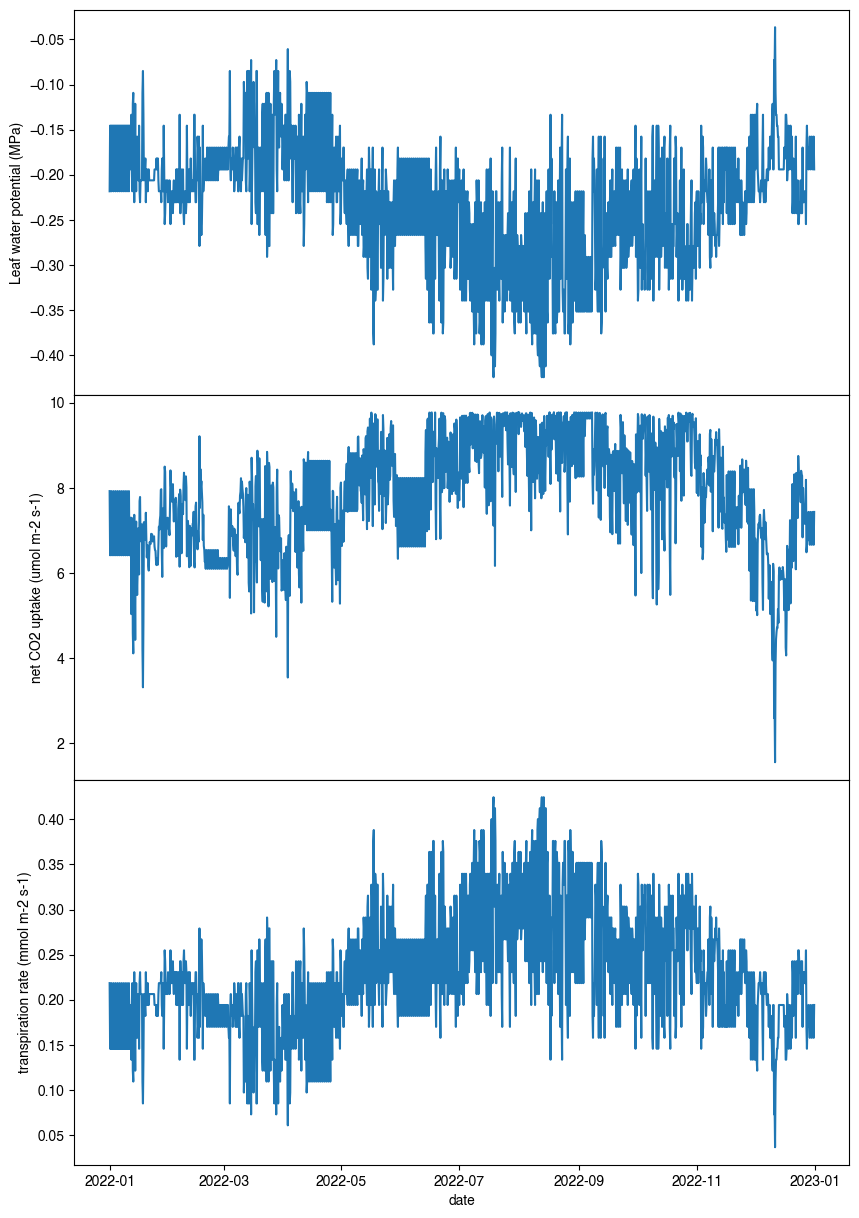

In [13]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the data
axis[0].plot(model_results.index.to_numpy(), model_results['leaf water potential'].to_numpy())
axis[1].plot(model_results.index.to_numpy(), model_results['net CO2 uptake'].to_numpy())
axis[2].plot(model_results.index.to_numpy(), model_results['transpiration rates'].to_numpy())

# Add labels
axis[0].set_ylabel("Leaf water potential (MPa)")
axis[1].set_ylabel("net CO2 uptake (umol m-2 s-1)")
axis[2].set_ylabel("transpiration rate (mmol m-2 s-1)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

There is a lot of noise in these plots, this is due to us ploting the results every half hour throughout the day. To solve this problem we resample the net $CO_2$ uptake to per day, calculate the mean transpiration rate for each day and record the leaf water potential at pre dawn (6 am) and midday.

In [14]:
# We want the net CO2 per day and the average transpiration rate so lets use padas resample
model_results_per_day = model_results[['net CO2 uptake', 'transpiration rates']].copy()

# net CO2 uptake is currently per second so we need to convert to per timestep
model_results_per_day['net CO2 uptake'] = model_results_per_day['net CO2 uptake'] * target_time_step * 60 * 60

# Resample per time step to per day
model_results_per_day = model_results_per_day.resample('D').agg({'net CO2 uptake':'sum', 'transpiration rates':'mean'})

# Get the predawn and miday leaf water potential. This code shifts the values to the start of the day then pandas matches them based on the asigned time
model_results_per_day['predawn leaf water potential'] = model_results['leaf water potential'].shift(periods = -1)
model_results_per_day['midday leaf water potential'] = model_results['leaf water potential'].shift(periods = -2)

print(model_results_per_day)

            net CO2 uptake  transpiration rates  predawn leaf water potential  \
date time                                                                       
2022-01-01   608722.056413             0.169854                     -0.145594   
2022-01-02   608722.056413             0.169854                     -0.145594   
2022-01-03   608722.056413             0.169854                     -0.145594   
2022-01-04   608722.056413             0.169854                     -0.145594   
2022-01-05   608722.056413             0.169854                     -0.145594   
...                    ...                  ...                           ...   
2022-12-27   626415.791810             0.215346                     -0.218391   
2022-12-28   601883.403008             0.169855                     -0.169860   
2022-12-29   614462.155119             0.178953                     -0.181993   
2022-12-30   614462.155119             0.178953                     -0.181993   
2022-12-31   614462.155119  

For consistency later we want to change the $\text{CO}_2$ uptake from $\text{umol m}^{-2}\text{ d}^{-1}$ to $\text{g C m}^{-2}\text{ d}^{-1}$.

In [15]:
print(model_results_per_day['net CO2 uptake'])

# Convert from umol to mol
model_results_per_day['net CO2 uptake'] = magnitude_conversion(model_results_per_day['net CO2 uptake'], 'u', '')

print(model_results_per_day['net CO2 uptake'])

# Convert from mol to g
model_results_per_day['net CO2 uptake'] = mole_carbon_to_grams(model_results_per_day['net CO2 uptake'])

print(model_results_per_day['net CO2 uptake'])

date time
2022-01-01    608722.056413
2022-01-02    608722.056413
2022-01-03    608722.056413
2022-01-04    608722.056413
2022-01-05    608722.056413
                  ...      
2022-12-27    626415.791810
2022-12-28    601883.403008
2022-12-29    614462.155119
2022-12-30    614462.155119
2022-12-31    614462.155119
Freq: D, Name: net CO2 uptake, Length: 365, dtype: float64
date time
2022-01-01    0.608722
2022-01-02    0.608722
2022-01-03    0.608722
2022-01-04    0.608722
2022-01-05    0.608722
                ...   
2022-12-27    0.626416
2022-12-28    0.601883
2022-12-29    0.614462
2022-12-30    0.614462
2022-12-31    0.614462
Freq: D, Name: net CO2 uptake, Length: 365, dtype: float64
date time
2022-01-01    7.304665
2022-01-02    7.304665
2022-01-03    7.304665
2022-01-04    7.304665
2022-01-05    7.304665
                ...   
2022-12-27    7.516990
2022-12-28    7.222601
2022-12-29    7.373546
2022-12-30    7.373546
2022-12-31    7.373546
Freq: D, Name: net CO2 uptake, Length:

We also want to convert the transpiraion rate to latent heat flux in $\text{W m}^{-2}$. Note that by making this conversion we are calculating the average rate over the day.

In [16]:
# mmol to mol (mol m-2 s-1)
model_results_per_day['latent energy'] = \
    magnitude_conversion(model_results_per_day['transpiration rates'], 'm', '')

# transpiration to latent energy (W m-2)
model_results_per_day['latent energy'] = convert_transpiration_rate_to_latent_energy(model_results_per_day['latent energy'])

Now everything is in the right units we can plot the results

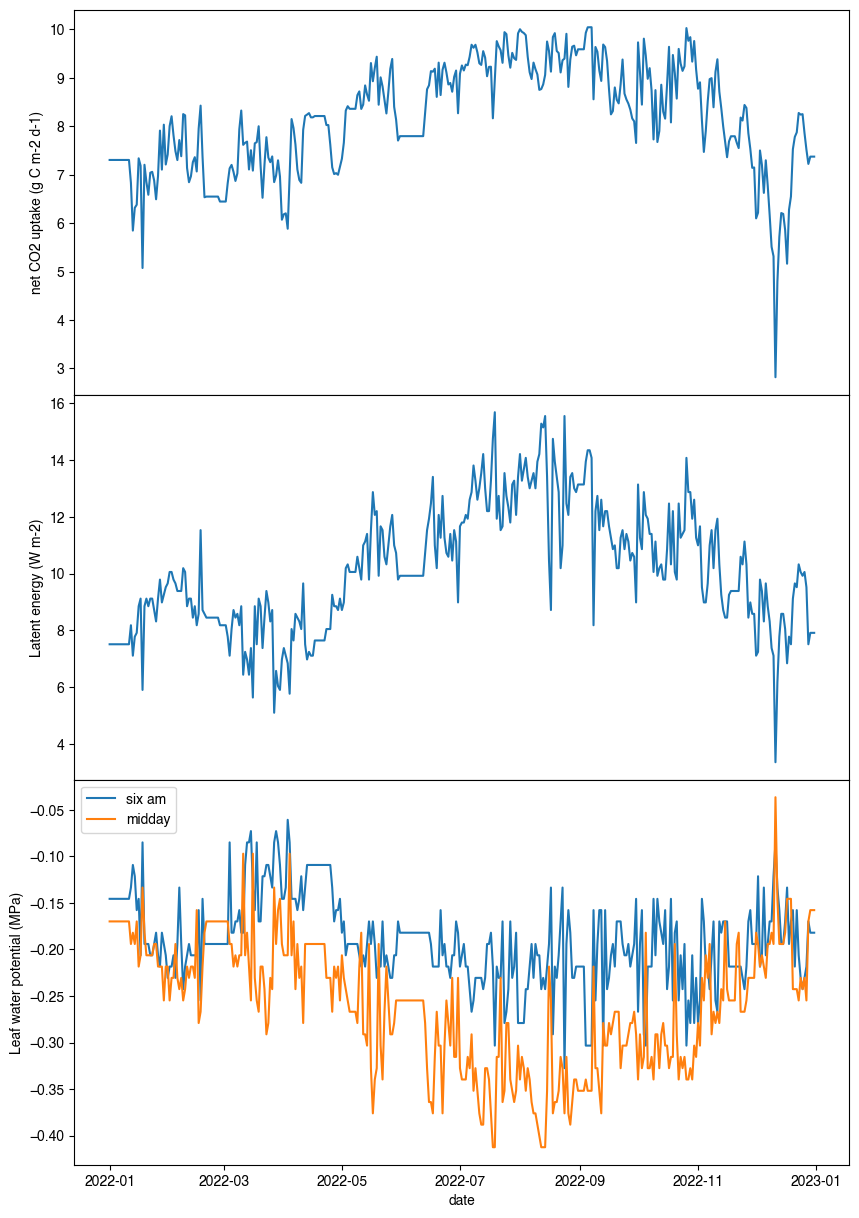

In [17]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the net CO2 uptake
axis[0].plot(model_results_per_day.index.to_numpy(), model_results_per_day['net CO2 uptake'].to_numpy())

# Plot the transpiration rate
axis[1].plot(model_results_per_day.index.to_numpy(), model_results_per_day['latent energy'].to_numpy())

# Plot the leaf water potential
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['predawn leaf water potential'].to_numpy(), label = 'six am')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['midday leaf water potential'].to_numpy() , label = 'midday')
axis[2].legend()

# Add labels
axis[0].set_ylabel("net CO2 uptake (g C m-2 d-1)")
axis[1].set_ylabel("Latent energy (W m-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

# Comparing results

Now we can compare the results of running the model above to those from JULES and CABLE along with real observations. To achive this we need to first load and reformat the results files as we did for the metoffice data.

In [18]:
JULES_data_file_address = "../../Example met data/local_UK-Ham_fluxnet2015_UK-Ham.UK-Ham.nc"
CABLE_data_file_address = "../../Example met data/hydraulics_profitmax_manon.nc"
observation_data_file_address = "../../Example met data/Alice_Holt/data/alice_holt_flux_2022.nc"

# Load files
JULES_data = open_dataset(JULES_data_file_address, decode_times=False)
CABLE_data = open_dataset(CABLE_data_file_address, decode_times=False)
observation_data = open_dataset(observation_data_file_address, decode_times=False)

# Reduce to relevant columns
JULES_data = JULES_data[['GPP', 'Qle', 'fsmc']]
CABLE_data = CABLE_data[['GPP', 'Qle', 'psi_rootzone', 'psi_can']]
observation_data = observation_data[['Qle']]

# Reduce dimentions
JULES_data = JULES_data.squeeze(dim=["x", "y"], drop = True)
CABLE_data = CABLE_data.squeeze(dim=["x", "y", "patch"], drop = True)
observation_data = observation_data.squeeze(dim=["x", "y"], drop = True)

# Extract Beta from jules data and then drop fsmc
JULES_data['beta'] = JULES_data['fsmc'][:,0]
JULES_data = JULES_data[['GPP', 'Qle', 'beta']]

# Get start date
JULES_units, JULES_reference_date = JULES_data.time.attrs['units'].split('since')
CABLE_units, CABLE_reference_date = CABLE_data.time.attrs['units'].split('since')
observation_units, observation_reference_date = observation_data.time.attrs['units'].split('since')

# Change start date formating
JULES_start_date = JULES_reference_date.strip()[0:19].replace("-","/")
CABLE_start_date = CABLE_reference_date.strip()[0:19].replace("-","/")
observation_start_date = observation_reference_date.strip()[0:19].replace("-","/")

# Convert to pandas object
JULES_data = JULES_data.to_pandas()
CABLE_data = CABLE_data.to_pandas()
observation_data = observation_data.to_pandas()

# Add date time column (this needs to be done affter converting to pandas or it is treated as an aditional dimention)
JULES_data['date time'] = date_range(start = JULES_start_date, periods = len(JULES_data), freq = '30MIN')
CABLE_data['date time'] = date_range(start = CABLE_start_date, periods = len(CABLE_data), freq = '30MIN')
observation_data['date time'] = date_range(start = observation_start_date, periods = len(observation_data), freq = '30MIN')

# Set the 'date time' colun as an index
JULES_data = JULES_data.set_index('date time')
CABLE_data = CABLE_data.set_index('date time')

print("JULES: \n", JULES_data, "\n")
print("CABLE: \n", CABLE_data, "\n")
print("observations: \n", observation_data, "\n")

JULES: 
                      GPP       Qle  beta
date time                               
2022-01-01 00:00:00  0.0 -0.067324   1.0
2022-01-01 00:30:00  0.0 -0.079333   1.0
2022-01-01 01:00:00  0.0 -0.263981   1.0
2022-01-01 01:30:00  0.0 -0.061631   1.0
2022-01-01 02:00:00  0.0 -0.331570   1.0
...                  ...       ...   ...
2022-12-31 21:30:00  0.0 -2.954634   1.0
2022-12-31 22:00:00  0.0 -1.310926   1.0
2022-12-31 22:30:00  0.0 -1.031563   1.0
2022-12-31 23:00:00  0.0 -1.772175   1.0
2022-12-31 23:30:00  0.0 -3.248971   1.0

[17520 rows x 3 columns] 

CABLE: 
                      GPP       Qle  psi_rootzone   psi_can
date time                                                 
2022-01-01 00:00:00  0.0 -7.058563     -0.029366 -0.029366
2022-01-01 00:30:00  0.0 -2.340145     -0.029344 -0.029344
2022-01-01 01:00:00  0.0  0.030474     -0.029325 -0.029325
2022-01-01 01:30:00  0.0  1.196649     -0.029308 -0.029308
2022-01-01 02:00:00  0.0  1.908619     -0.029291 -0.029291
...     

This data needs to be converted to the same units as that produced using the model.

Let us start with the JULES data

In [19]:
JULES_data_per_day = JULES_data.copy()

# First make the carbon uptake rate grams per half hour from kilograms per second
JULES_data_per_day['GPP'] = magnitude_conversion(JULES_data_per_day['GPP'], 'k', '')
JULES_data_per_day['GPP'] = per_second_to_per_half_hour(JULES_data_per_day['GPP'])

# Resample the results to per day taking the sum of the CO2 uptake, mean latent heat and minimum beta
JULES_data_per_day = JULES_data_per_day.resample("D").agg({'GPP':'sum', 'Qle':'mean', 'beta':'min'})

print(JULES_data_per_day)

                 GPP       Qle  beta
date time                           
2022-01-01  0.782950 -0.391202   1.0
2022-01-02  0.753786 -0.797297   1.0
2022-01-03  0.799369 -0.318914   1.0
2022-01-04  0.830902 -0.402620   1.0
2022-01-05  1.158851 -0.159758   1.0
...              ...       ...   ...
2022-12-27  0.019233 -0.302093   1.0
2022-12-28  0.017166 -2.111282   1.0
2022-12-29  0.021375 -1.037430   1.0
2022-12-30  0.017020 -1.733438   1.0
2022-12-31  0.014291 -3.065119   1.0

[365 rows x 3 columns]


Now for the CABLE data.

In [20]:
CABLE_data_per_day = CABLE_data[['GPP','Qle']].copy()

# convert GPP from umol m-2 s-1 to g C m-2 (0.5h)-1
CABLE_data_per_day['GPP'] = magnitude_conversion(CABLE_data_per_day['GPP'], 'u', '')
CABLE_data_per_day['GPP'] = per_second_to_per_half_hour(CABLE_data_per_day['GPP'])
CABLE_data_per_day['GPP'] = mole_carbon_to_grams(CABLE_data_per_day['GPP'])

# Remove any negative latent heat so they are not averaged over
CABLE_data_per_day['Qle'].loc[CABLE_data_per_day['Qle'] < 0] = nan

# Resample
CABLE_data_per_day = CABLE_data_per_day.resample("D").agg({'GPP':'sum', 'Qle':'mean'})

# Add the pre dawn (6 am) and midday leaf water potentials
CABLE_data_per_day['predawn leaf water potential'] = CABLE_data['psi_can'].resample("D", offset = "6h" ).asfreq().iloc[1:].to_numpy()
CABLE_data_per_day['midday leaf water potential']      = CABLE_data['psi_can'].resample("D", offset = "12h").asfreq().iloc[1:].to_numpy()

print(CABLE_data_per_day)

                     GPP        Qle  predawn leaf water potential  \
date time                                                           
2022-01-01  2.175093e-01   9.080814                     -0.029192   
2022-01-02  7.562412e-02  17.028246                     -0.027503   
2022-01-03  8.178637e-10  10.053499                     -0.026339   
2022-01-04  4.172413e-02  14.993724                     -0.027104   
2022-01-05  7.728097e-01  19.769239                     -0.027341   
...                  ...        ...                           ...   
2022-12-27  0.000000e+00   2.345288                     -0.005895   
2022-12-28  0.000000e+00   0.239332                     -0.005895   
2022-12-29  0.000000e+00   2.670970                     -0.005895   
2022-12-30  0.000000e+00   0.972046                     -0.005895   
2022-12-31  0.000000e+00        NaN                     -0.005895   

            midday leaf water potential  
date time                                
2022-01-01        

Now we can compare these data sets to the results of the model implimented above.

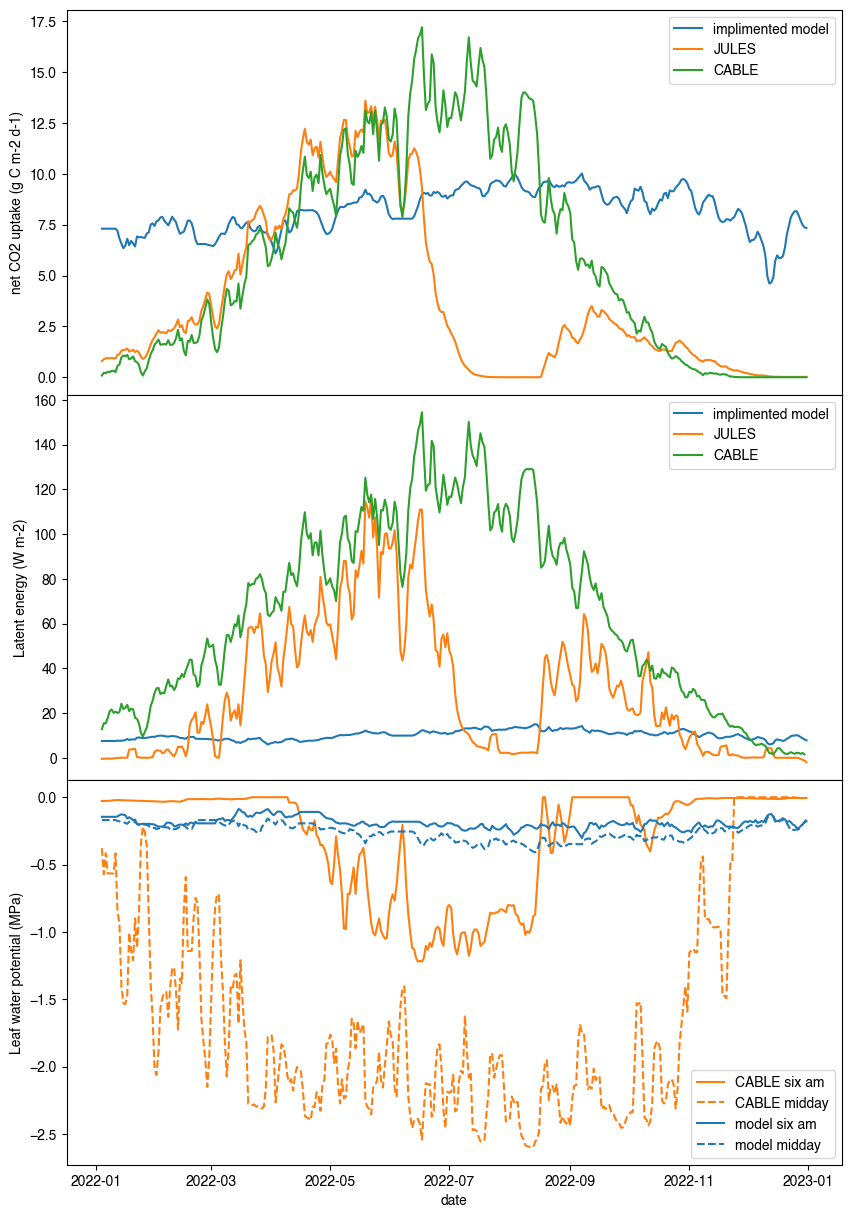

In [24]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the net CO2 uptake
axis[0].plot(model_results_per_day.index.to_numpy(), model_results_per_day['net CO2 uptake'].to_numpy(), label = 'implimented model')
axis[0].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['GPP'].to_numpy()              , label = 'JULES')
axis[0].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['GPP'].to_numpy()              , label = 'CABLE')
axis[0].legend()

# Plot the average latent heat flux for each day
axis[1].plot(model_results_per_day.index.to_numpy(), model_results_per_day['latent energy'].to_numpy(), label = 'implimented model')
axis[1].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['Qle'].to_numpy()             , label = 'JULES')
axis[1].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['Qle'].to_numpy()             , label = 'CABLE')
axis[1].legend()

# Plot the leaf water potential
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['predawn leaf water potential'].to_numpy()   , label = 'CABLE six am', c = '#ff7f0e')
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['midday leaf water potential'].to_numpy()    , label = 'CABLE midday', c = '#ff7f0e', linestyle = '--')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['predawn leaf water potential'].to_numpy(), label = 'model six am', c = '#1f77b4')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['midday leaf water potential'].to_numpy() , label = 'model midday', c = '#1f77b4', linestyle = '--')
axis[2].legend()

# Add labels
axis[0].set_ylabel("net CO2 uptake (g C m-2 d-1)")
axis[1].set_ylabel("Latent energy (W m-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)

There is a lot of noise here so lets smooth all the data using a rolling average to make it easier to read.

In [22]:
window = 4

print(model_results_per_day)
model_results_per_day = model_results_per_day.rolling(window).mean()
JULES_data_per_day = JULES_data_per_day.rolling(window).mean()
CABLE_data_per_day = CABLE_data_per_day.rolling(window).mean()
print(model_results_per_day)

            net CO2 uptake  transpiration rates  predawn leaf water potential  \
date time                                                                       
2022-01-01        7.304665             0.169854                     -0.145594   
2022-01-02        7.304665             0.169854                     -0.145594   
2022-01-03        7.304665             0.169854                     -0.145594   
2022-01-04        7.304665             0.169854                     -0.145594   
2022-01-05        7.304665             0.169854                     -0.145594   
...                    ...                  ...                           ...   
2022-12-27        7.516990             0.215346                     -0.218391   
2022-12-28        7.222601             0.169855                     -0.169860   
2022-12-29        7.373546             0.178953                     -0.181993   
2022-12-30        7.373546             0.178953                     -0.181993   
2022-12-31        7.373546  

Now we can replot this smoothed data

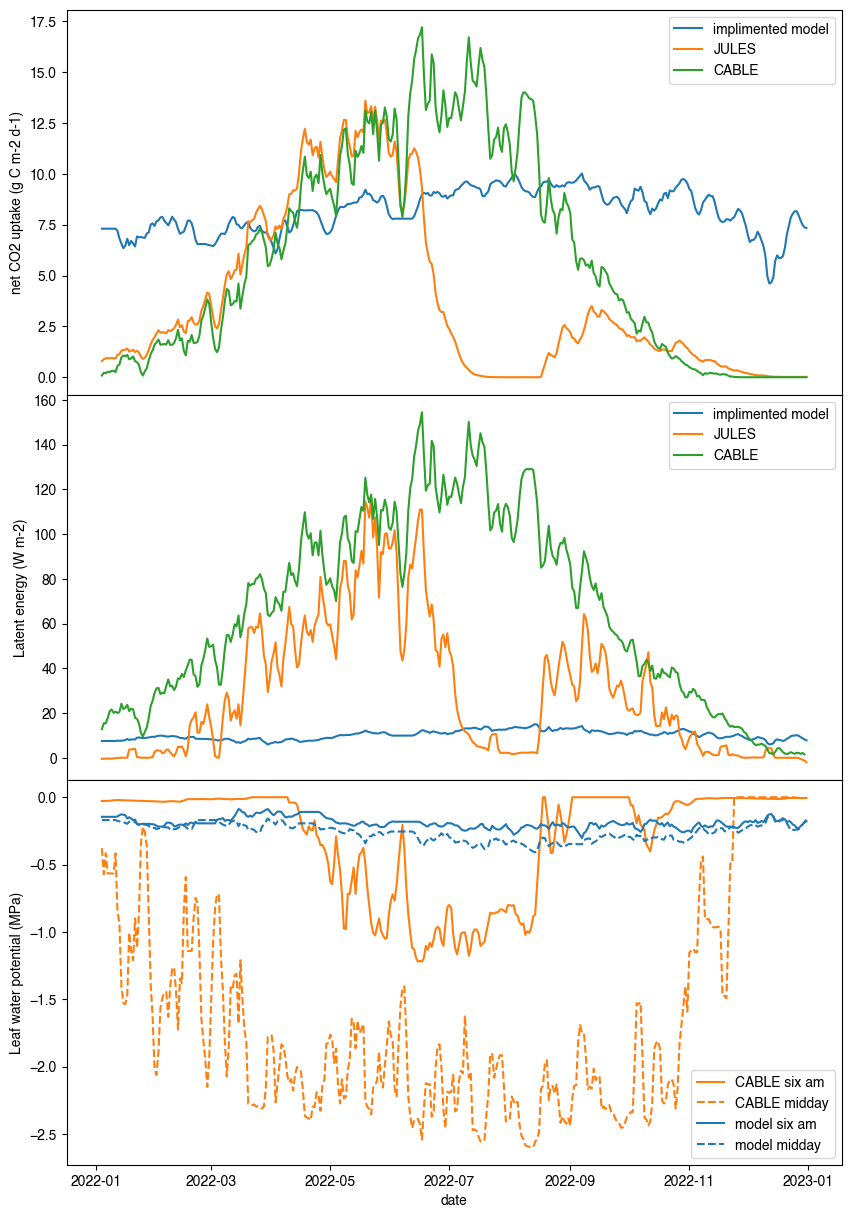

In [25]:
fig, axis = plt.subplots(3, sharex=True)

# Plot the net CO2 uptake
axis[0].plot(model_results_per_day.index.to_numpy(), model_results_per_day['net CO2 uptake'].to_numpy(), label = 'implimented model')
axis[0].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['GPP'].to_numpy()              , label = 'JULES')
axis[0].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['GPP'].to_numpy()              , label = 'CABLE')
axis[0].legend()

# Plot the average latent heat flux for each day
axis[1].plot(model_results_per_day.index.to_numpy(), model_results_per_day['latent energy'].to_numpy(), label = 'implimented model')
axis[1].plot(JULES_data_per_day.index.to_numpy()   , JULES_data_per_day['Qle'].to_numpy()             , label = 'JULES')
axis[1].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['Qle'].to_numpy()             , label = 'CABLE')
axis[1].legend()

# Plot the leaf water potential
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['predawn leaf water potential'].to_numpy()   , label = 'CABLE six am', c = '#ff7f0e')
axis[2].plot(CABLE_data_per_day.index.to_numpy()   , CABLE_data_per_day['midday leaf water potential'].to_numpy()    , label = 'CABLE midday', c = '#ff7f0e', linestyle = '--')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['predawn leaf water potential'].to_numpy(), label = 'model six am', c = '#1f77b4')
axis[2].plot(model_results_per_day.index.to_numpy(), model_results_per_day['midday leaf water potential'].to_numpy() , label = 'model midday', c = '#1f77b4', linestyle = '--')
axis[2].legend()

# Add labels
axis[0].set_ylabel("net CO2 uptake (g C m-2 d-1)")
axis[1].set_ylabel("Latent energy (W m-2)")
axis[2].set_ylabel("Leaf water potential (MPa)")
axis[2].set_xlabel("date")

# Remove vertical space between sublpots
fig.subplots_adjust(hspace = 0)

# Set figure size
fig.set_size_inches(10,15)